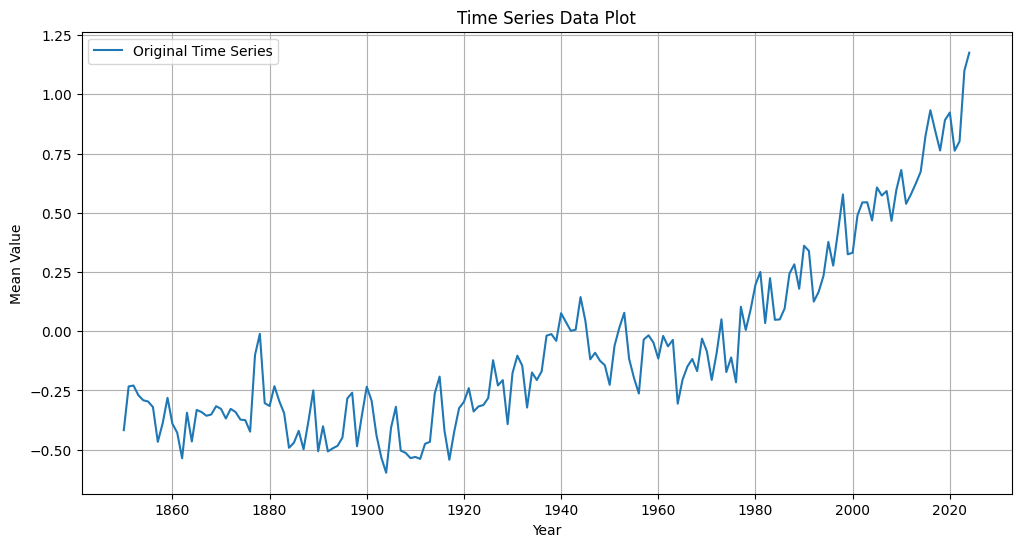

ADF Statistic: 2.476446005370727
p-value: 0.999041859406313
Critical Values:
   1%: -3.470126426071447
   5%: -2.8790075987120027
   10%: -2.5760826967621644
Conclusion: Data is not stationary (Fail to Reject H0)


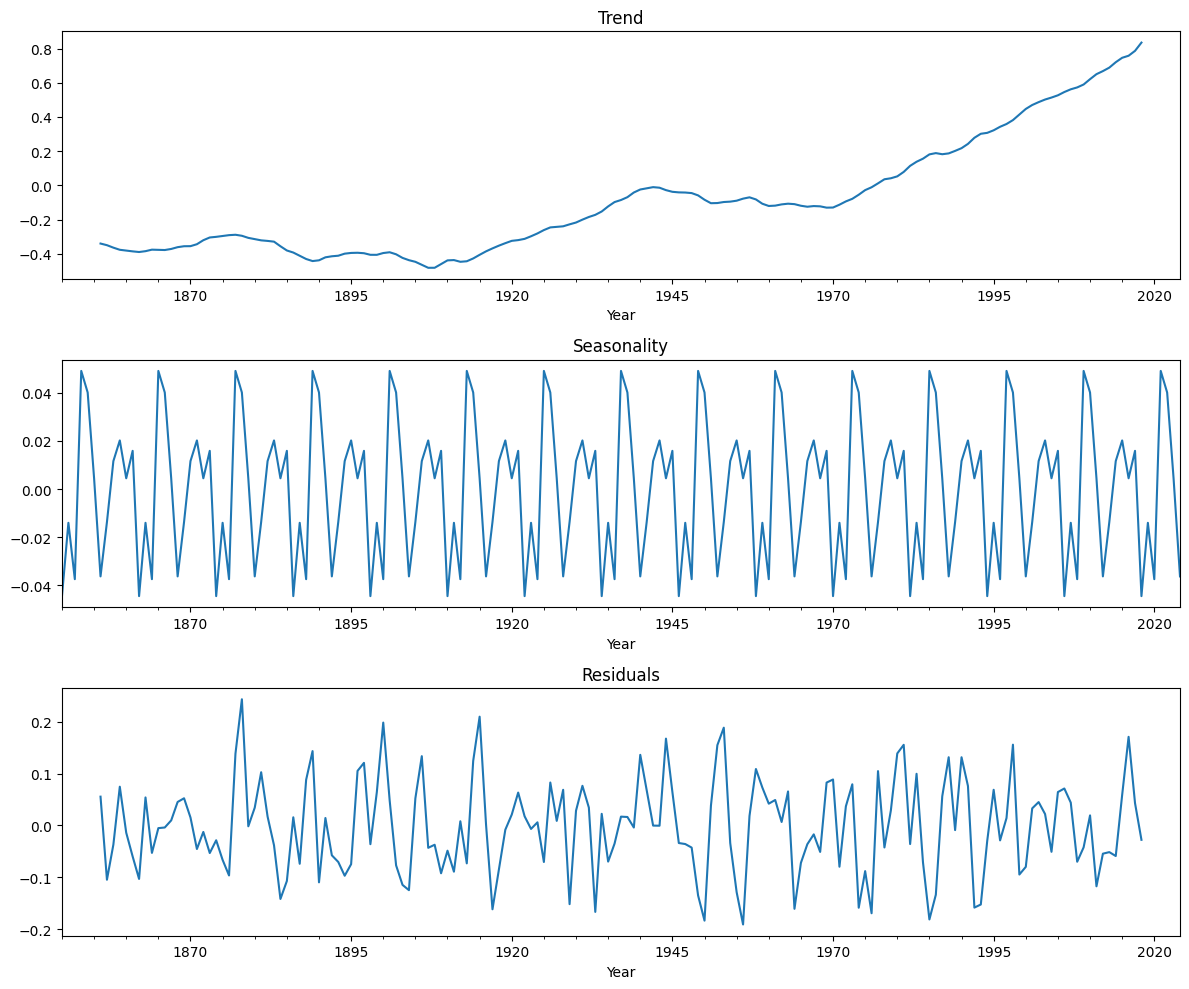

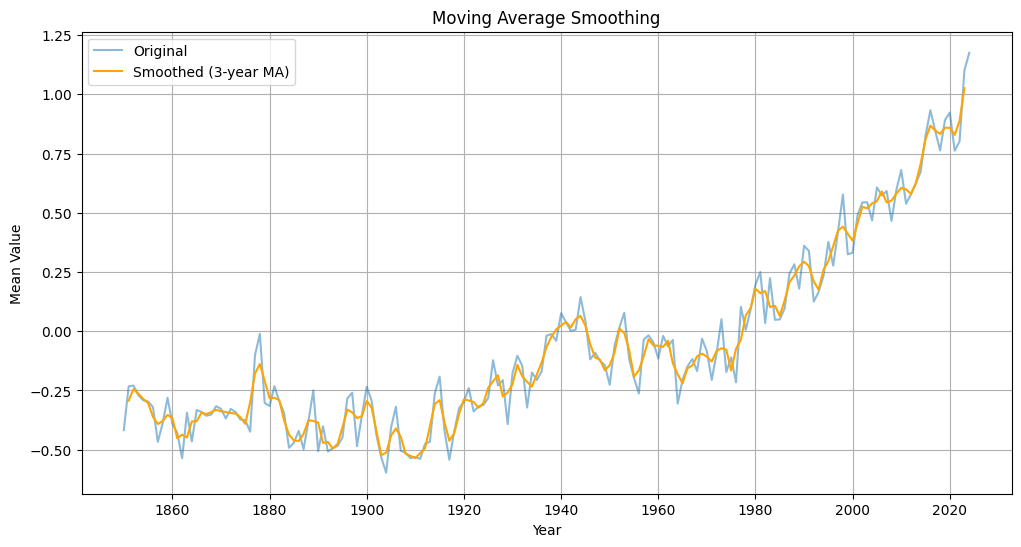

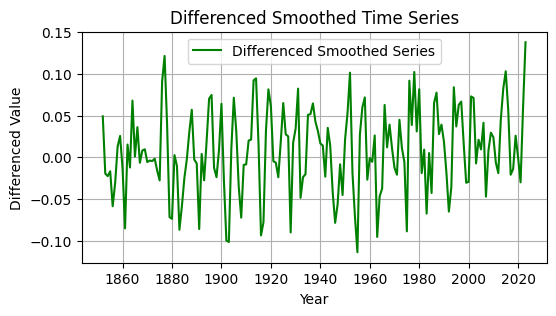

ADF Statistic after smoothing and differencing: -3.1283231772604925
p-value: 0.024526920779433137
Critical Values:
   1%: -3.472703119504854
   5%: -2.880131672353732
   10%: -2.5766826861130268
Conclusion: Data is stationary (Reject H0)


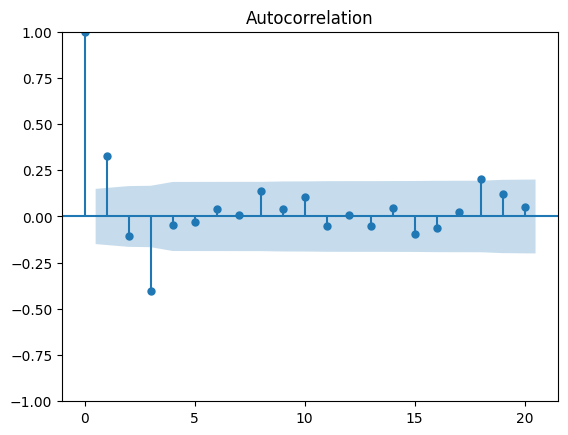

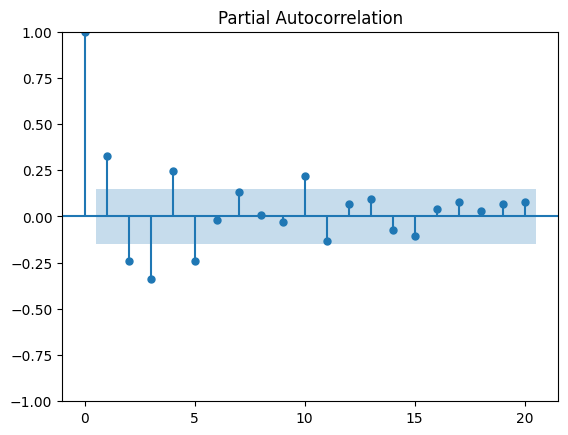

C:\Users\Jayashrinidhi V\AppData\Local\Temp\ipykernel_13500\2527611467.py:114: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=10, freq='Y')


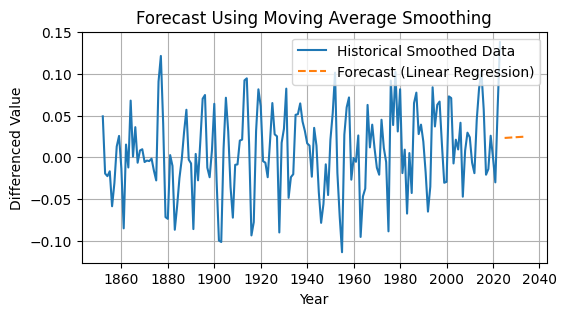

        Year  Forecasted Smoothed Mean
0 2024-12-31                  0.023252
1 2025-12-31                  0.023430
2 2026-12-31                  0.023608
3 2027-12-31                  0.023786
4 2028-12-31                  0.023965
5 2029-12-31                  0.024142
6 2030-12-31                  0.024320
7 2031-12-31                  0.024498
8 2032-12-31                  0.024677
9 2033-12-31                  0.024855


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data
filepath = 'C://Users//Jayashrinidhi V//OneDrive//Documents//VScode//TimeSeriesAnalysis//globaltemp.csv'
df = pd.read_csv(filepath, parse_dates=['Year'])
df.set_index('Year', inplace=True)

# Remove duplicate indices
df = df[~df.index.duplicated(keep='first')]

# Ensure column selection for plotting
if 'Mean' not in df.columns:
    raise ValueError("Column 'Mean' not found in the dataset. Check the CSV file.")

# Plot original time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Mean'], label='Original Time Series')
plt.xlabel("Year")
plt.ylabel("Mean Value")
plt.title("Time Series Data Plot")
plt.legend()
plt.grid()
plt.show()

# Perform ADF test before differencing
result = adfuller(df['Mean'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")
if result[1] <= 0.05:
    print("Conclusion: Data is stationary (Reject H0)")
else:
    print("Conclusion: Data is not stationary (Fail to Reject H0)")

# Seasonal Decomposition
decomposition = seasonal_decompose(df['Mean'], model='additive', period=12)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
decomposition.trend.plot(ax=ax1, title='Trend')
decomposition.seasonal.plot(ax=ax2, title='Seasonality')
decomposition.resid.plot(ax=ax3, title='Residuals')
plt.tight_layout()
plt.show()

# Moving Average Smoothing
df['Smoothed'] = df['Mean'].rolling(window=3, center=True).mean()

# Plot smoothed series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Mean'], label='Original', alpha=0.5)
plt.plot(df.index, df['Smoothed'], label='Smoothed (3-year MA)', color='orange')
plt.xlabel("Year")
plt.ylabel("Mean Value")
plt.title("Moving Average Smoothing")
plt.legend()
plt.grid()
plt.show()

# Apply differencing to smoothed data
df['Smoothed_Diff'] = df['Smoothed'].diff(1)
df.dropna(inplace=True)

# Plot differenced smoothed series
plt.figure(figsize=(6, 3))
plt.plot(df.index, df['Smoothed_Diff'], label='Differenced Smoothed Series', color='green')
plt.xlabel("Year")
plt.ylabel("Differenced Value")
plt.title("Differenced Smoothed Time Series")
plt.legend()
plt.grid()
plt.show()

# Perform ADF test on differenced smoothed data
result = adfuller(df['Smoothed_Diff'].dropna())
print("ADF Statistic after smoothing and differencing:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")
if result[1] <= 0.05:
    print("Conclusion: Data is stationary (Reject H0)")
else:
    print("Conclusion: Data is not stationary (Fail to Reject H0)")

# Plot ACF and PACF
tsaplots.plot_acf(df['Smoothed_Diff'].dropna(), lags=20)
tsaplots.plot_pacf(df['Smoothed_Diff'].dropna(), lags=20)
plt.show()

# Linear Regression Forecasting
# Ensure index is datetime for regression
df.index = pd.to_datetime(df.index, errors='coerce')
df.dropna(inplace=True)  # Drop rows with NaT if any

# Convert datetime index to ordinal for regression
X = df.index.map(lambda x: x.toordinal()).values.reshape(-1, 1)
y = df['Smoothed_Diff'].values.reshape(-1, 1)

# Fit Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# Predict future 10 years
last_date = df.index[-1]
future_years = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=10, freq='Y')
X_future = future_years.map(lambda x: x.toordinal()).values.reshape(-1, 1)
y_pred = model.predict(X_future)

# Plot forecast
plt.figure(figsize=(6, 3))
plt.plot(df.index, df['Smoothed_Diff'], label='Historical Smoothed Data')
plt.plot(future_years, y_pred, label='Forecast (Linear Regression)', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Differenced Value")
plt.title("Forecast Using Moving Average Smoothing")
plt.legend()
plt.grid()
plt.show()

# Optional: Print forecast values
forecast_df = pd.DataFrame({'Year': future_years, 'Forecasted Smoothed Mean': y_pred.flatten()})
print(forecast_df)
